<a href="https://colab.research.google.com/github/SaifEleslamElgalaly/food-101-classification/blob/main/Pre_trained_Deep_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-trained Deep Learning Model

In [ ]:
# import torch
# import torch.nn as nn
# from torchvision import models, transforms, datasets
# from torch.utils.data import DataLoader
# import torch.optim as optim
# from tqdm import tqdm


In [ ]:
mean = [0.5498, 0.4451, 0.3431]
std = [0.2638, 0.2641, 0.2688]

transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


In [ ]:
train_dir = '/kaggle/working/food-101-split/train'
val_dir = '/kaggle/working/food-101-split/val'

train_data = datasets.ImageFolder(train_dir, transform=transform_train)
val_data = datasets.ImageFolder(val_dir, transform=transform_val)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

num_classes = len(train_data.classes)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# تجميد كل الطبقات ماعدا الـ classifier
for param in model.parameters():
    param.requires_grad = False

# تعديل الطبقة الأخيرة
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {acc:.2f}%")


100%|██████████| 256/256 [01:51<00:00,  2.29it/s]


Epoch 1, Loss: 371.4610, Accuracy: 57.44%


100%|██████████| 256/256 [01:51<00:00,  2.30it/s]


Epoch 2, Loss: 242.4355, Accuracy: 70.93%


100%|██████████| 256/256 [01:49<00:00,  2.35it/s]


Epoch 3, Loss: 221.7957, Accuracy: 72.68%


100%|██████████| 256/256 [01:49<00:00,  2.33it/s]


Epoch 4, Loss: 205.9998, Accuracy: 74.09%


100%|██████████| 256/256 [01:49<00:00,  2.35it/s]


Epoch 5, Loss: 202.8980, Accuracy: 75.21%


100%|██████████| 256/256 [01:50<00:00,  2.32it/s]


Epoch 6, Loss: 194.7288, Accuracy: 75.69%


100%|██████████| 256/256 [01:48<00:00,  2.36it/s]


Epoch 7, Loss: 195.0246, Accuracy: 75.67%


100%|██████████| 256/256 [01:48<00:00,  2.36it/s]


Epoch 8, Loss: 183.6097, Accuracy: 77.13%


100%|██████████| 256/256 [01:53<00:00,  2.26it/s]


Epoch 9, Loss: 178.6913, Accuracy: 77.50%


100%|██████████| 256/256 [01:52<00:00,  2.27it/s]

Epoch 10, Loss: 176.9166, Accuracy: 77.72%


In [ ]:
model.eval()
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (preds == labels).sum().item()

val_acc = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 72.76%


==============================================================================================

In [ ]:
features = []
labels = []
image_paths = []

with torch.no_grad():
    for inputs, targets in tqdm(loader):
        inputs = inputs.to(device)
        outputs = model(inputs)  # output shape: [batch, 2048, 1, 1]
        outputs = outputs.view(outputs.size(0), -1)  # flatten to [batch, 2048]

        features.append(outputs.cpu().numpy())
        labels.extend(targets.numpy())

        # استخراج اسم الصورة
        batch_paths = [dataset.imgs[i][0] for i in range(len(labels) - len(targets), len(labels))]
        image_paths.extend(batch_paths)

# دمجهم في DataFrame
features_np = np.concatenate(features, axis=0)
df = pd.DataFrame(features_np)
df['label'] = labels
df['image_path'] = image_paths
df.to_csv("/kaggle/working/resnet50_features.csv", index=False)


100%|██████████| 256/256 [00:50<00:00,  5.11it/s]


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
from torchvision import transforms as T

In [ ]:
# Augmentation قوية للتدريب
train_transform = transforms.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.5498, 0.4451, 0.3431],
                std=[0.2638, 0.2641, 0.2688])
])

val_transform = transforms.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5498, 0.4451, 0.3431],
                std=[0.2638, 0.2641, 0.2688])
])

# تحميل البيانات
data_dir = "/kaggle/working/food-101-split"
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)

# تعديل الطبقة الأخيرة لعدد الأصناف
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Fine-tune فقط الطبقات الأخيرة
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)


In [ ]:
best_acc = 0

for epoch in range(10):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / total

    # Evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_resnet50.pth")
        print("✅ New Best Model Saved!")


100%|██████████| 256/256 [01:54<00:00,  2.23it/s]


Epoch 1, Train Acc: 69.08%, Val Acc: 77.55%
✅ New Best Model Saved!


100%|██████████| 256/256 [01:55<00:00,  2.22it/s]


Epoch 2, Train Acc: 80.01%, Val Acc: 80.13%
✅ New Best Model Saved!


100%|██████████| 256/256 [01:55<00:00,  2.22it/s]


Epoch 3, Train Acc: 85.27%, Val Acc: 82.56%
✅ New Best Model Saved!


100%|██████████| 256/256 [01:54<00:00,  2.23it/s]


Epoch 4, Train Acc: 89.36%, Val Acc: 77.21%


100%|██████████| 256/256 [01:54<00:00,  2.23it/s]


Epoch 5, Train Acc: 90.87%, Val Acc: 83.46%
✅ New Best Model Saved!


100%|██████████| 256/256 [01:52<00:00,  2.27it/s]


Epoch 6, Train Acc: 93.05%, Val Acc: 81.65%


100%|██████████| 256/256 [01:52<00:00,  2.28it/s]


Epoch 7, Train Acc: 93.43%, Val Acc: 83.95%
✅ New Best Model Saved!


100%|██████████| 256/256 [01:51<00:00,  2.30it/s]


Epoch 8, Train Acc: 94.91%, Val Acc: 82.97%


100%|██████████| 256/256 [01:51<00:00,  2.29it/s]


Epoch 9, Train Acc: 95.46%, Val Acc: 82.90%


100%|██████████| 256/256 [01:50<00:00,  2.31it/s]


Epoch 10, Train Acc: 95.94%, Val Acc: 85.75%
✅ New Best Model Saved!


In [ ]:
test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5498, 0.4451, 0.3431],
                std=[0.2638, 0.2641, 0.2688])
])


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

test_dir = "/kaggle/working/food-101-split/test"
test_data = ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
import torch
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=False)
num_classes = len(test_data.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load("/kaggle/working/best_resnet50.pth"))
model = model.to(device)
model.eval()


/tmp/ipykernel_31/3250003365.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best_resnet50.pth"))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# عرض النتيجة
acc = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


✅ Test Accuracy: 86.75%


In [ ]:
from sklearn.metrics import classification_report

print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_data.classes))


📊 Classification Report:
                precision    recall  f1-score   support

     apple_pie       0.67      0.66      0.67       225
 bread_pudding       0.72      0.68      0.70       217
  caesar_salad       0.97      0.87      0.92       226
    cheesecake       0.86      0.84      0.85       228
        donuts       0.84      0.94      0.89       219
  french_fries       0.96      0.97      0.97       218
grilled_salmon       0.84      0.84      0.84       217
     ice_cream       0.85      0.88      0.87       208
         pizza       0.98      0.87      0.93       214
         ramen       0.97      0.94      0.96       222
        samosa       0.93      0.86      0.89       213
         steak       0.81      0.90      0.85       227
         sushi       0.91      0.93      0.92       215
         tacos       0.90      0.90      0.90       222
       waffles       0.83      0.93      0.88       219

      accuracy                           0.87      3290
     macro avg       

Test Accuracy: 86.75%
                precision    recall  f1-score   support

     apple_pie       0.67      0.66      0.67       225
 bread_pudding       0.72      0.68      0.70       217
  caesar_salad       0.97      0.87      0.92       226
    cheesecake       0.86      0.84      0.85       228
        donuts       0.84      0.94      0.89       219
  french_fries       0.96      0.97      0.97       218
grilled_salmon       0.84      0.84      0.84       217
     ice_cream       0.85      0.88      0.87       208
         pizza       0.98      0.87      0.93       214
         ramen       0.97      0.94      0.96       222
        samosa       0.93      0.86      0.89       213
         steak       0.81      0.90      0.85       227
         sushi       0.91      0.93      0.92       215
         tacos       0.90      0.90      0.90       222
       waffles       0.83      0.93      0.88       219

      accuracy                           0.87      3290
     macro avg       0.8

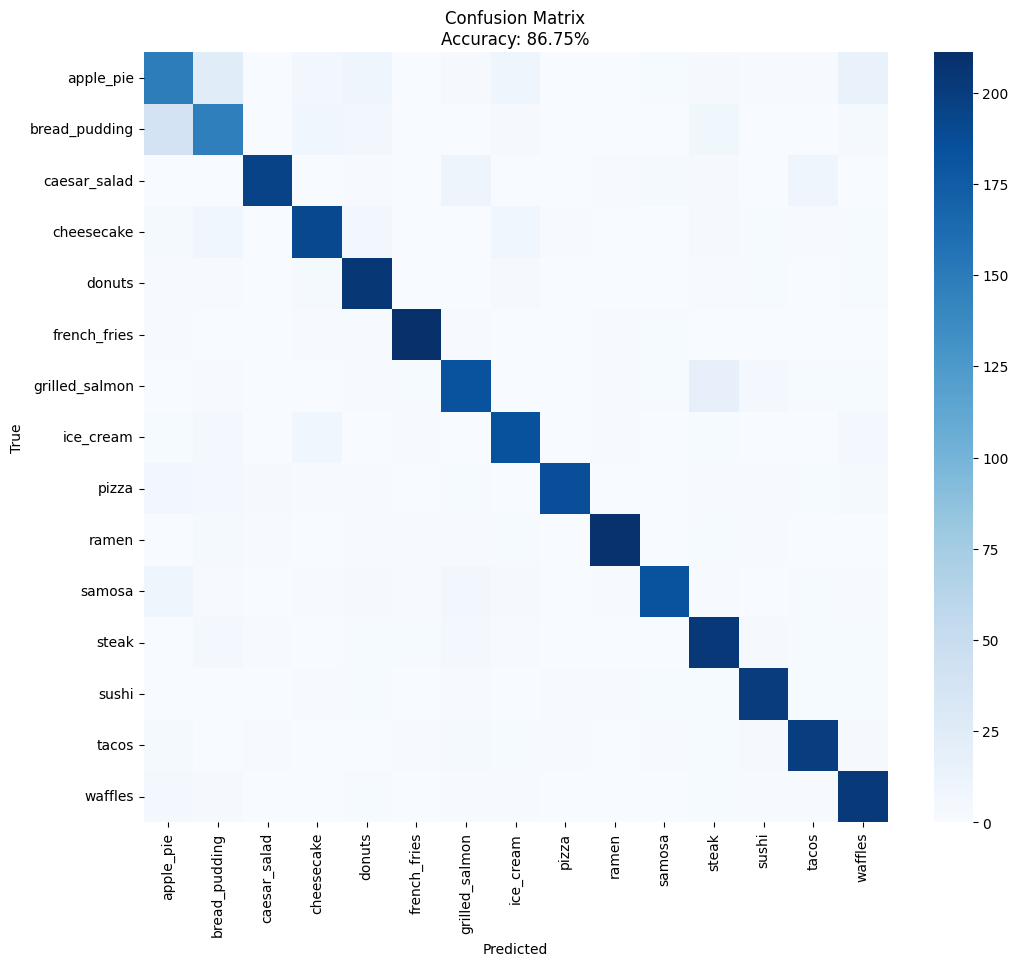

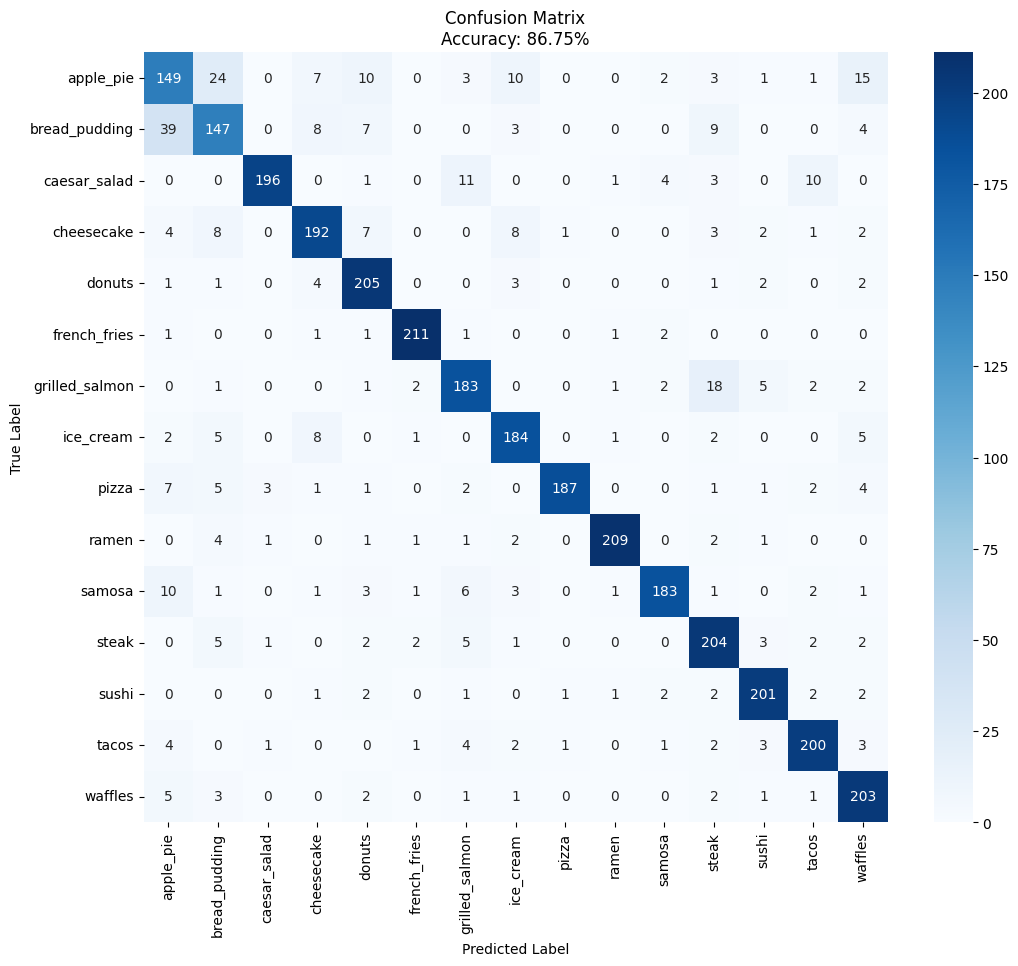

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# بعد ما تعمل prediction
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc*100:.2f}%")
print(classification_report(all_labels, all_preds, target_names=class_names))

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix\nAccuracy: {acc*100:.2f}%")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title(f"Confusion Matrix\nAccuracy: {acc*100:.2f}%")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


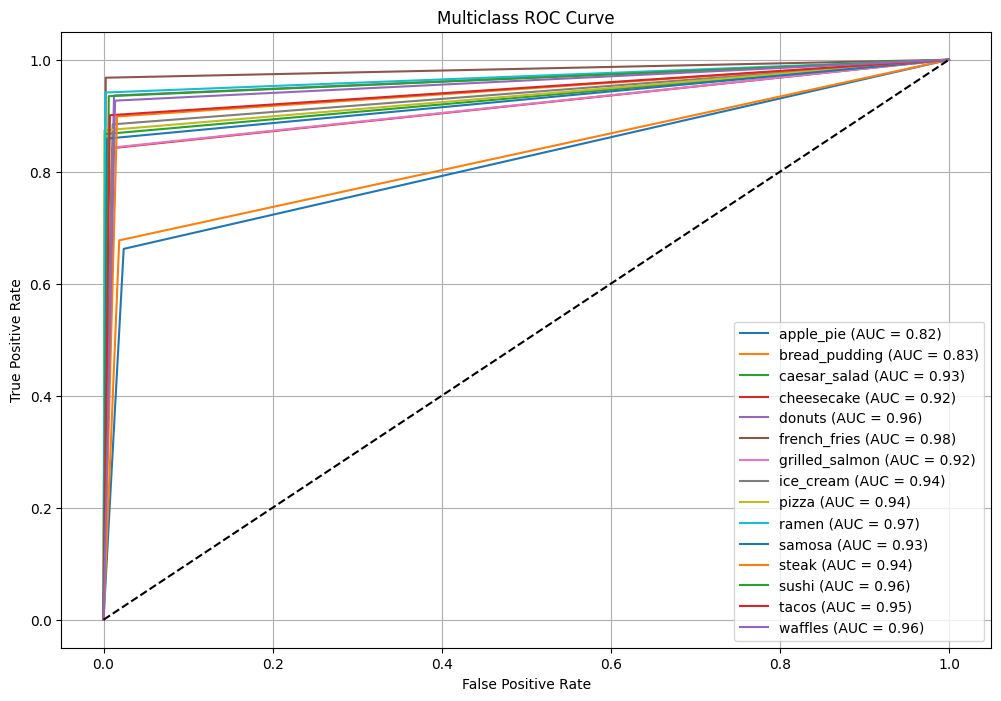

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# تحويل التروث والبرِدكشن إلى one-hot
y_true_bin = label_binarize(all_labels, classes=range(len(class_names)))
y_pred_bin = label_binarize(all_preds, classes=range(len(class_names)))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# رسم ROC Curve
plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


                  Model  Test Accuracy  Macro F1-score
0          Proposed CNN          72.00            0.72
1  Pre-trained ResNet50          86.75            0.87


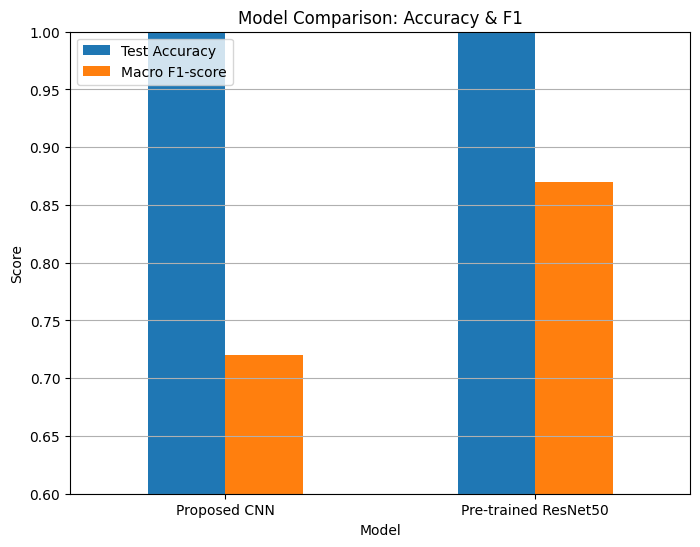

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# مقارنة يدوية بالقيم اللي عندك
comparison_df = pd.DataFrame({
    "Model": ["Proposed CNN", "Pre-trained ResNet50"],
    "Test Accuracy": [72.00, 86.75],
    "Macro F1-score": [0.72, 0.87]
})

# عرض الجدول
print(comparison_df)

# رسم Bar Chart للمقارنة
comparison_df.set_index("Model").plot(kind="bar", figsize=(8, 6), rot=0)
plt.title("Model Comparison: Accuracy & F1")
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
plt.grid(axis="y")
plt.legend(loc="upper left")
plt.show()
